In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d lucassj/dogs-vs-cats-train-validadion-and-evaluation

 98% 1.05G/1.07G [00:11<00:00, 88.5MB/s]
100% 1.07G/1.07G [00:11<00:00, 98.7MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [20]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
 

--2021-07-01 13:03:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   209MB/s    in 0.4s    

2021-07-01 13:03:30 (209 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [8]:
pre_trained = InceptionV3(input_shape=(150, 150, 3),
                          include_top=False,
                          weights=None)

In [9]:
pre_trained.load_weights(local_weights_file)

In [11]:
for layer in pre_trained.layers:
  layer.trainable = False

In [12]:
last_layer = pre_trained.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [27]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(2, activation='softmax')(x)
model = Model(pre_trained.input, x)

In [28]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [21]:
generator = ImageDataGenerator(
    rescale=1/255
)

train_generator = generator.flow_from_directory(
    "/content/data/train",
    target_size=(150, 150),
    batch_size=18,
    class_mode='categorical'
)

validation_generator = generator.flow_from_directory(
    "/content/data/validation",
    target_size=(150, 150),
    batch_size=18,
    class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [30]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1112/1112 [==============================] - 84s 73ms/step - loss: 0.1631 - accuracy: 0.9518 - val_loss: 0.1339 - val_accuracy: 0.9642
Epoch 2/5
1112/1112 [==============================] - 80s 72ms/step - loss: 0.0863 - accuracy: 0.9778 - val_loss: 0.1519 - val_accuracy: 0.9678
Epoch 3/5
1112/1112 [==============================] - 79s 71ms/step - loss: 0.0494 - accuracy: 0.9866 - val_loss: 0.1968 - val_accuracy: 0.9646
Epoch 4/5
1112/1112 [==============================] - 80s 72ms/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 0.2547 - val_accuracy: 0.9614
Epoch 5/5
1112/1112 [==============================] - 80s 72ms/step - loss: 0.0148 - accuracy: 0.9965 - val_loss: 0.2593 - val_accuracy: 0.9678


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
model.save('/content/drive/MyDrive/Models(AI)/cats_vs_dogs_v3.h5')

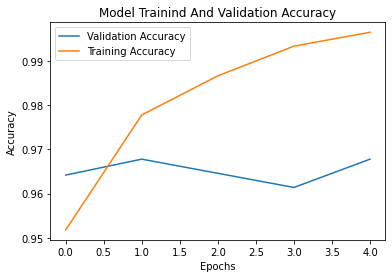

In [35]:
import matplotlib.pyplot as plt

epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(epochs, history.history['accuracy'], label = 'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Model Trainind And Validation Accuracy")
plt.legend()

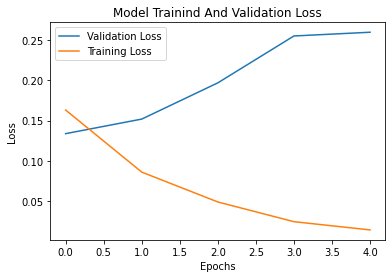

In [36]:
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['val_loss'], label = 'Validation Loss')
plt.plot(epochs, history.history['loss'], label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Model Trainind And Validation Loss")
plt.legend()

Overfitting occurs you can fix this by using data augmentation techniques.